# Feed Forward Neural Network in pure Python
> <span style="color:gray"> Created by Mikkel Vilstrup ([mvil](https://github.com/MVilstrup))

In this notebook we demonstrate how to implement a neural network from scratch using basic programming concepts and pure Python. It is intended for people who are not fully comfortable with linear algebra in order to show what is going on in "simpler" terms. 

We construct the network without the convenience of linear algebra and use simple for-loops instead. 
The problem we are going to solve is the **half-moons problem**. 
This problem is used because of it is simple yet cannot be solved with linear functions alone, e.g. Logistic Regression.
It is also convenient because models can be trained quickly and the results can be visualized easily.

In order to solve it with a neural network we will go through:
* Selecting a non-linear activation function
* Implementing the forward propagation
* Implementing the backward propagation
* Training the network on the dataset

## Dependancies and supporting functions
Load all dependancies and supporting functions by running the code block below.

In [2]:
# Import some librarires that we need
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import sys, os
sys.path.append(os.path.join('.', '..')) # Allow us to import shared custom 
                                         # libraries, like utils.py
from intro_utils import (onehot, mesh_grid, prediction_contours)
    
from sklearn.datasets import make_moons
from IPython.display import clear_output
from IPython import display
from time import sleep
from sklearn.metrics import precision_score, accuracy_score
from random import shuffle

## The half-moon data set

Before begining to model it is always a good idea to explore the data.

It is impossible to know when to stop a neural network from training using only one data set.
The neural network might get to 99% accuracy on the training set, while still having very poor performance on new data.
In this case it has **overfitted** to features in the training set that is unique to this particular partition of the data, and not the data as a whole.

In order to overcome this problem we tend to extract a tiny partition of the dataset which we call the **validation set**.
We can then use the accuracy of the validation set to judge when it is appropriate to stop the training. 
This set is not used to update the parameters, but monitor the progress during training, which is an indirect form of training.
We must therefore create yet another partition, the test set, which we are only allowed to use as the final validation of the model.
The **test set** is used for the results that are reported

In this notebook we are lazy and combine the test/validation set, but in general this is a no-no.

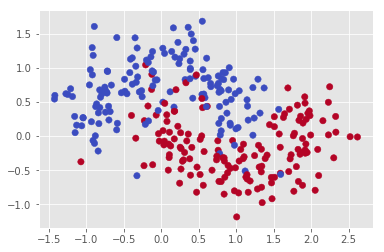

In [3]:
## Load and visualize the half-moon data set
train_size = 300
test_size = 60
noise = 0.3

X_train, Y_train = make_moons(train_size, noise=noise)
X_test, Y_test = make_moons(test_size, noise=noise)

train_data = list(zip(X_train, onehot(Y_train, 2)))
test_data = list(zip(X_test, onehot(Y_test, 2)))

plt.scatter(X_train[:,0], X_train[:,1], s=40, c=Y_train, cmap=plt.cm.coolwarm)
plt.show()

### Initializing variables
The parameters in a neural networ are initialized randomly following some distribution.
In our extremely simplified neural network we only need to know three things:
* The amount of features of the data we train on (2 in our case)
* The number of hidden units we want in our hidden layer
* The number of possible classes available in the dataset (2 in our case)

With this knowledge we can go about and define the variables we need.
In order to make this network as simple as possible we will save a lot of information explicitly. 
There are two things to pay attention to in the code below:

* The sizes of the weights
* Te way the the bias is implemented. You will always add a bias when you multiply a data feature with a weight during training.

In the following notebooks this will be done explicitly.
However, here we do it implicitly by adding a single neuron which we will not update ourselves.
This node will end up doing the same as a bias since all weights will be summed together. 

In [4]:
def initialize(input_dimensions, hidden_dimensions, output_dimensions):
    input_nodes = input_dimensions + 1 # We add one to have room for bias node
    hidden_nodes = hidden_dimensions
    output_nodes = output_dimensions

    # Initilize arrays of 1s for activations 
    # These need to be ones since we will multiply them with the inputs
    input_activations = np.ones(input_nodes)
    hidden_activations = np.ones(hidden_nodes)
    output_activations = np.ones(output_nodes)

    # Initialize randomized weights
    # This initialization is very simplistic and naive. Normally we would need 
    # to think more about the initial values since they impact the performance of the algorithm
    # However, Deep learning frameworks tend to do this for us
    input_weights = np.random.randn(input_nodes, hidden_nodes)
    output_weights = np.random.randn(hidden_nodes, output_nodes)

    # Initialize a cache used to store the last step size in backpropagation
    input_stepsize = np.zeros((input_nodes, hidden_nodes)) # Input x Hidden
    output_stepsize = np.zeros((hidden_nodes, output_nodes)) # Hidden x Output
    
    return (input_nodes, hidden_nodes, output_nodes, input_activations, hidden_activations, 
            output_activations, input_weights, output_weights, input_stepsize, output_stepsize)

### Choosing activation functions

With the variables in place we need to choose a non-linearity for our activation function.
Using a non-linear activation function is fundamental for deep learning.
This is because all other parts of deep learning is simply mulitplying weights to the input which is a linear function.
Without a non-liniear activation function any network regardless of its size or shape would thus only be able to represent linear functions.

Activation functions are still a hot research topic and new activation functions appear regularly.
However, there are a few which have been proven to work over and over again.
Of these Sigmoid and TanH are the most classical choices, and was the preffered activation functions for many years. 

Recently the trend is moving towards more minimalistic activation functions which generally only differ from linear functions when the input is less than zero.
In theory any non-linear function can be used as long as its derivative can be computed efficiently.
However, in practice the functions shown below tend to do very well, and one should have a really good reason to try and come up with a new activation function instead of just using one of the existing.

Below several common nonliear activation functions are implemented and described.
Remember to use the TensorFlow implemention in your code, NOT the implementaions below!
TensorFlow provides the [most commonly used nonliearities](https://www.tensorflow.org/api_guides/python/nn).
Wikipedia has a [much longer list](https://en.wikipedia.org/wiki/Activation_function#Comparison_of_activation_functions) that can be fun to look at.

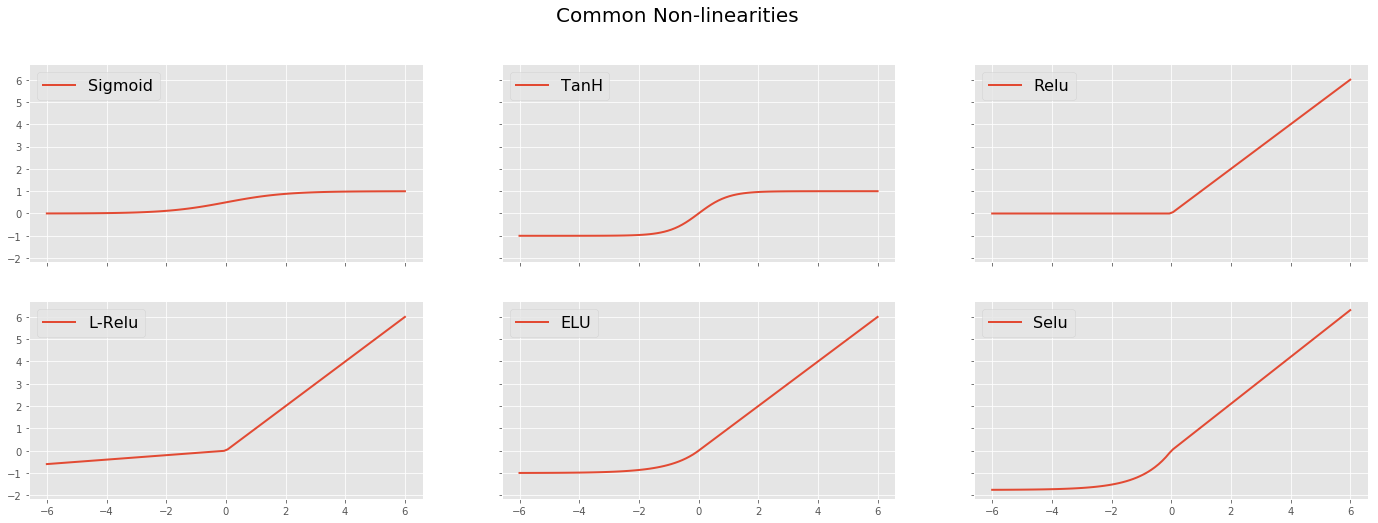

In [5]:
# Sigmoid Activation Function
# Sigmoid was initially the most common choice for activation functions. However, it was shown to be much worse than
# the activation functions below. Now it is used for gating and to approximate percentages 
# (by setting the value between 0 and 1)
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

# TanH Activation Function
# TanH was also a very popular activation function. It is still the activation function of choice in 
# Recurrent Neural Networks (RNNs) but it is almost never used in Convolutional Neural Networks (CNNs) or 
# Feed Forward Neural Netowrks (FFNs).
def tanh(x):
    return (1 - np.exp(-2*x)) / (1 + np.exp(-2*x))

# Relu Activation Function
# Relus are likely the most common activation functions used in CNNs and FFNs. It seems to be a good choice
# since all the best performing models use it. The theory of why it works is that it is seemingly the simplest
# Non-linearity possible. This is because it is linear in all positive values of x. 
# However, sometimes one encounter the problem of dead neurons with Relu where the output of the neuron will be zero
# no matter the input. 
def relu(x):
    return max(0., x)

# Leaky Relu Activation Function
# Leaky Relu is almost the same as Relu. It sometimes works better than Relu, but the main advantage is that
# neurons cannot die since it can output both positive and negative values. 
def leaky_relu(x):
    return max(0., x) + 0.1 * min(0, x)

# Elu Activation function
# https://arxiv.org/pdf/1511.07289.pdf
# Elu also resembles Relu quite a lot. The biggest difference is that Relu is capped at 0, 
# whereas Elu is capped at -1.
def elu(x, alpha=1):
    return x if x >= 0 else alpha * (np.exp(x) - 1)

# Selu activatiosn function
# Selu is only shown here because it is the newest kid on the block from June 8, 2017. 
# The aim is to add a self-normalizing property to the neural network in order to decrease variance 
# and training errors. The Selu activation push neuron activations to zero mean and unit variance thereby 
# leading to the same effect as batch normalization, which enables to robustly learn many layers. 
# However, in order to use it we need to handle weight initialization properly which we do not do here. 
# https://arxiv.org/pdf/1706.02515.pdf
def selu(x, alpha=1.6732632423543772848170429916717, scale=1.0507009873554804934193349852946):
    return scale * x if x > 0 else scale * (alpha * np.exp(x) - alpha)
    
X = np.linspace(-6, 6, 100)
labels = ['Sigmoid',
          'TanH',
          'Relu',
          'L-Relu',
          'ELU',
          'Selu']
data = [[sigmoid(x) for x in X],
        [tanh(x) for x in X],
        [relu(x) for x in X],
        [leaky_relu(x) for x in X],
        [elu(x) for x in X],
        [selu(x) for x in X]]

rows = 2
columns = int(len(labels) / rows)
fig, axn = plt.subplots(rows, columns, figsize=(8*columns,4*rows), sharey=True, sharex=True)
plt.suptitle('Common Non-linearities', fontsize=20)

for i, row in enumerate(axn):
    for j, ax in enumerate(row):
        index = i*columns+j
        ax.plot(X, data[index], label=labels[index], lw=2)
        ax.legend(loc=2, fontsize=16)

One of the reasons why the field moved away from Sigmoid and TanH is the dissapearing gradients when the absolute value of the weights increases.
It's only in a small range centered around 0, that the gradient of the activation functions is big enough for efficient learning to occur.
When the absolute value increases the gradient vanishes which influences the learning curve. 

With the newer functions which are linear for positive weights the gradient only vanishes with negative weights.
This has been shown to have a positive effect on the convergence rate.

A general advice is thus to start out with the Relu activation function and then try the other functions if the performance does not live up to expectations. 

#### Gradients of activation functions

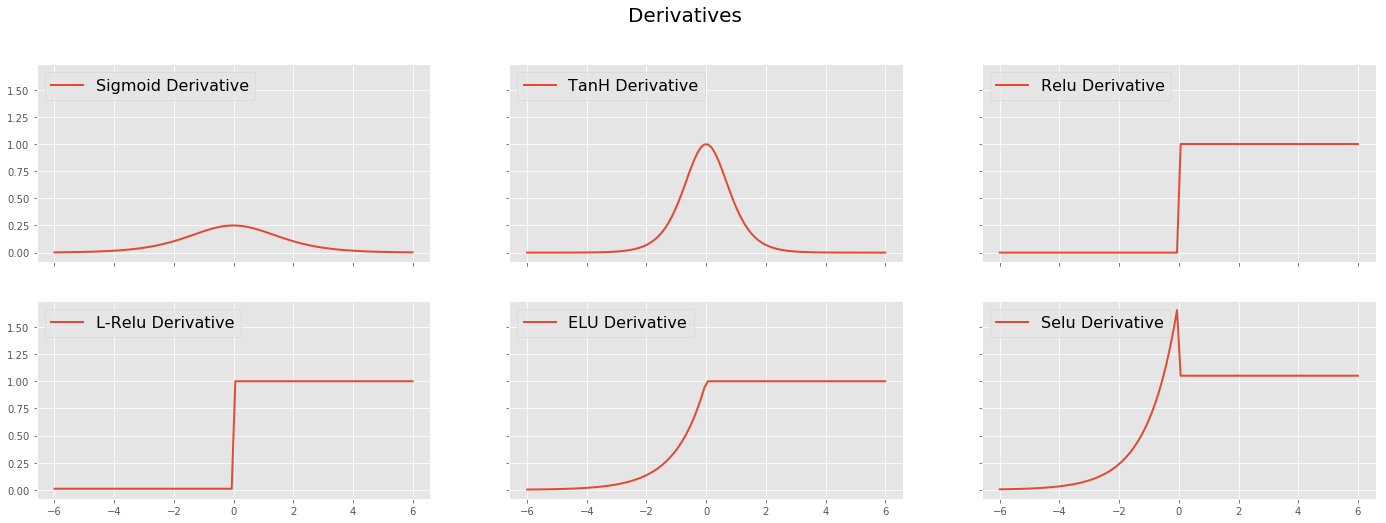

In [6]:
X = np.linspace(-6, 6, 100)

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def tanh_derivative(y):
    return 1 - np.square(tanh(y))

def relu_derivative(x):
    return 1. if x > 0. else 0.

def leaky_relu_derivative(x):
    return 1 if x >= 0 else 0.01

def elu_derivative(x, alpha=1):
    return 1 if x >= 0 else elu(x, alpha) + alpha

def selu_derivative(x, alpha=1.6732632423543772848170429916717, scale=1.0507009873554804934193349852946):
    return scale if x > 0 else scale * alpha * np.exp(x)

labels = ['Sigmoid Derivative',
          'TanH Derivative',
          'Relu Derivative',
          'L-Relu Derivative',
          'ELU Derivative',
          'Selu Derivative']
data = [[sigmoid_derivative(x) for x in X],
        [tanh_derivative(x) for x in X],
        [relu_derivative(x) for x in X],
        [leaky_relu_derivative(x) for x in X],
        [elu_derivative(x) for x in X],
        [selu_derivative(x) for x in X]]

rows = 2
columns = int(len(labels) / rows)
fig, axn = plt.subplots(rows, columns, figsize=(8*columns,4*rows), sharey=True, sharex=True)
plt.suptitle('Derivatives', fontsize=20)

for i, row in enumerate(axn):
    for j, ax in enumerate(row):
        index = i*columns+j
        ax.plot(X, data[index], label=labels[index], lw=2)
        ax.legend(loc=2, fontsize=16)

## Forward Propagation
With the variables initialized and the activation function chosen. We are ready to define the forward propagation function used to map the input to a prediction. 
The forward propagation is a relatively simple function.
In each layer we multiply the input with the weights and add a bias (implicitly).
The result of each of these linear operations we transform with our non-linear activation function. 

In the final layer the output can either be out through a linear function (typically used for regression) or through a non-linear function such as we do here (typically used for classification). For classification the most normal function to use is [Softmax](https://en.wikipedia.org/wiki/Softmax_function) which transforms the output into a propability distributions indicating the likelyhood of the input belonging to each class.

In [7]:
def forward_propagation(inputs, activation_func):
    if len(inputs) != input_nodes - 1:
        raise ValueError("Wrong number of inputs ;) ({} instead of {})".format(len(inputs), input_nodes - 1))

    # Set all input activations to be equal to new inputs
    for i in range(input_nodes - 1): # we subtract one in order not to touch the last element (the bias)
        input_activations[i] = inputs[i]

    # Calculate the weighted value for each hidden neuron
    # Remember that in FFNs each neuron is connected to all neurons in the previous layer
    for i in range(hidden_nodes):
        value = 0.0
        for j in range(input_nodes):
            value += input_activations[j] * input_weights[j][i]

        hidden_activations[i] = activation_func(value) # Apply the non-linear function to the weighted value

    # Calculate the weighted value for each output neuron
    # !! Notice: This is almost the same as the step before !!
    for i in range(output_nodes):
        value = 0.0
        for j in range(hidden_nodes):
            value += hidden_activations[j] * output_weights[j][i]

        # Apply the sigmoid function to convert each activation to a value between 0 and 1.
        output_activations[i] = sigmoid(value)

    return output_activations

## Backward Propagation
Backpropagation is one of the primary reasons why deep learning is computationally tractable.
It is used to compute how much each weight contribute to the error of the network. 
This knowledge combined with an optimization algorithm is used to figure out which weights to tune and how much. 

We will not go into detail with backpropagation here, but only show how it can be written in python.

In [8]:
def backward_propagation(targets, learning_rate, activation_func_derivative):
    if len(targets) != output_nodes:
        raise ValueError("Wrong number of targets ;) ({} instead of {})".format(len(targets), output_nodes))

    # Initialize deltas cache. This cache is important since it would otherwise not be feasible to 
    # train deep neural networks. This is beacuse the derivative of any layer is dependent on the derivative
    # of the succeding layer.
    output_deltas = np.zeros(output_nodes)
    hidden_deltas = np.zeros(hidden_nodes)

    # Update the deltas for the output layer (As the algorithms' name applies we start from the back of the network)
    for i in range(output_nodes):
        error = -(targets[i] - output_activations[i]) 
        output_deltas[i] = sigmoid_derivative(output_activations[i]) * error

    # Update the deltas or the hidden layer
    for i in range(hidden_nodes):
        error = 0.0
        for j in range(output_nodes):
            error += output_deltas[j] * output_weights[i][j] # Here we use the cache

        hidden_deltas[i] = activation_func_derivative(hidden_activations[i]) * error

    # ------------------ END OF BACK PROPAGATION ------------------
    # From here we update the weights. 
    # This is the optimization algorithm and should not be confused with backpropagation. 
    # We just include the two in one function for simplicity
    # We use Stochastic Gradient Descent (SGD) as optimisation algorithm
    
    
    # Update the weights connecting the hidden layer to the output layer
    for i in range(hidden_nodes):
        for j in range(output_nodes):
            change = output_deltas[j] * hidden_activations[i]
            output_weights[i][j] -= learning_rate * change + output_stepsize[i][j]
            output_stepsize[i][j] = change

    # Update the weights connecting the input layer to the hidden layer
    for i in range(input_nodes):
        for j in range(hidden_nodes):
            change = hidden_deltas[j] * input_activations[i]
            input_weights[i][j] -= learning_rate * change + input_stepsize[i][j]
            input_stepsize[i][j] = change

    # Calculate Mean Squared Error
    # This is a very simple cost function and is almost never used for classification purposes
    # However, we will use it here anyway for simplicity
    error = sum((targets - output_activations) ** 2) / len(targets)

    return error

## Train and Prediction

With forward and backward propagation defined, the training the network is really simple.
One simply iterates through each input and propagate it through the network with forward propagation.
From here we calculate the error, and run back propagation to update the weights accordingly. 

The procedure for making predictions with the network is then just a single forward propagation through the network.
(We then run an argmax on the output vector to convert it back into the original classes defined by an integer)

In [9]:
def train(patterns, epochs, learning_rate, activation_func, activation_func_derivative):
    error_per_epoch = []
    for i in range(epochs):
        error = 0.0

        for p in patterns:
            inputs, targets = p

            forward_propagation(inputs, activation_func)
            error += backward_propagation(targets, learning_rate, activation_func_derivative)
            
        error_per_epoch.append(error) 
    
    return error_per_epoch

def predict(X):
    predictions = []

    for x in X:
        pred = forward_propagation(x, relu)
        pred = np.argmax(pred)
        predictions.append(pred)
    return np.array(predictions)

As shown above the code for training a network is quite simple when forward/back-propagation is defined (as well as cost function and choice of optimization funciton).
However, It is here we encounter one of the hardest parts of working with neural networks.
What is going on inside the network??

This is still an unsolved problem and many researchers spend all their time trying to come up with novel ways to get insights into why a network "acts" as it does.

In order to give you a slight insight into this network we have included another training function which does the exact same thing as the one above, except it includes a visualisation of the training data, evaluation data and the error. 

In [10]:
def train_with_animation(train_data, test_data, epochs = 10, learning_rate = 0.002, plot_step=2, activation_func=relu, activation_func_derivative=relu_derivative):
    num_frames = epochs

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,8))
    ax1.set_title("Train Targets")
    
    X_train, Y_train_orig = zip(*train_data)
    Y_train = [np.argmax(l) for l in Y_train_orig]
    X_train = np.array(X_train)

    # create a mesh to plot in
    xx_train, yy_train = mesh_grid(X_train)

    ax1.scatter(X_train[:, 0], X_train[:, 1], s=60, cmap=plt.cm.coolwarm)
    
    X_test, Y_test_orig = zip(*test_data)
    Y_test = [np.argmax(l) for l in Y_test_orig]
    X_test = np.array(X_test)
    
    # create a mesh to plot in
    xx_test, yy_test = mesh_grid(X_test)
    
    test_scat = ax2.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, s=60, cmap=plt.cm.coolwarm)

    cost = []
    for i in range(1, epochs + 1):
        error = 0.0
        
        for p in train_data:
            inputs, targets = p
            
            forward_propagation(inputs, activation_func)
            error += backward_propagation(targets, learning_rate, activation_func_derivative)
        
        plt.suptitle("Epoch: {}".format(i), fontsize=14, fontweight='bold')
        cost.append(error)
        if i % plot_step == 0:
            ax1.cla()
            pred_train = predict(X_train)
            train_precision = precision_score(Y_train, pred_train)
            train_accuracy = accuracy_score(Y_train, pred_train)
            ax1.set_title("Train Precision: {0:0.2f}, Train Accuracy: {1:0.2f}".format(train_precision, train_accuracy))
            ax1.scatter(X_train[:, 0], X_train[:, 1], s=60, c=Y_train, cmap=plt.cm.coolwarm)
            ax1.contourf(xx_train, yy_train, prediction_contours(xx_train, yy_train, predict), cmap=plt.cm.coolwarm, alpha=0.3)

            ax2.cla()
            pred_test = predict(X_test)
            test_precision = precision_score(Y_test, pred_test)
            test_accuracy = accuracy_score(Y_test, pred_test)
            ax2.set_title("Test Precision: {0:0.2f}, Test Accuracy: {1:0.2f}".format(test_precision, test_accuracy))
            ax2.scatter(X_test[:, 0], X_test[:, 1], s=60, c=Y_test, cmap=plt.cm.coolwarm)
            ax2.contourf(xx_test, yy_test, prediction_contours(xx_test, yy_test, predict), cmap=plt.cm.coolwarm, alpha=0.3)


            ax3.cla()
            ax3.set_title("Mean Squared Error: {0:0.2f}".format(error))
            ax3.plot(cost, label="Training Cost")
            ax3.legend()

            display.clear_output(wait=True)
            display.display(plt.gcf())    

Finally all we need is to define the hyperparameters.
This is simple in our case, since we have so few parameters.
However in more complex networks this can be a daunting task.
In many cases researchers end up using search algorithms to train the network with various parameters automatically instead of trying to fiddle with the parameters themselves. 

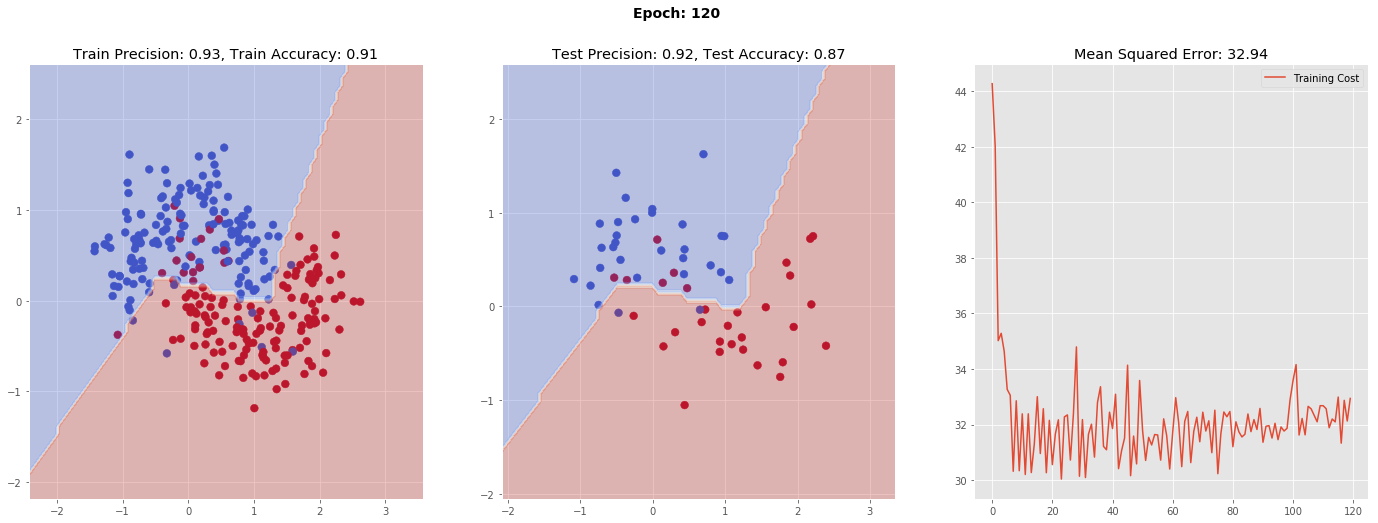

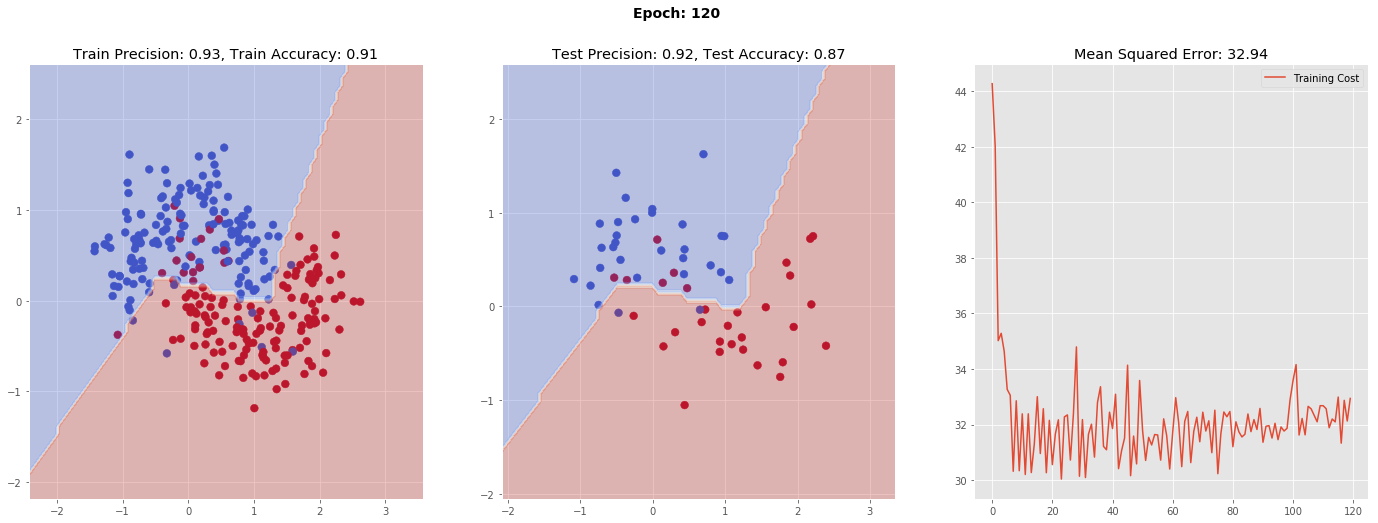

In [11]:
np.random.seed(0)

input_dimensions = 2 # N.B - This is fixed in our case
hidden_dimensions = 10 
output_dimensions = 2 # N.B - This is fixed in our case

epochs = 120
plot_steps = 5
learning_rate = 0.1

input_nodes, hidden_nodes, output_nodes,\
    input_activations, hidden_activations, output_activations,\
    input_weights, output_weights,\
    input_stepsize, output_stepsize = initialize(input_dimensions, hidden_dimensions, output_dimensions)

train_with_animation(train_data, test_data, epochs=epochs, learning_rate=learning_rate, plot_step=plot_steps)

# Assignments
1) Investigate the Non-Linearities
* Try the various activation functions and see how the network behaves
    * Which activation function achieves the lowest training cost?
    * Which activation function seems most stable?
* Try changing various hyper parameters
    * Does more/less hidden_dimensions help perfomance?
    * Does more training data (train_size) help?
    * What about learning rate? (Try making it very small or very large  *(e.g 0.00001 or 1.0)*)
    
2) What is the difference between precision and accuracy and why are they sometimes very different?</span>

3) What does the value Mean Squared Error (shown in the left most graph) represent in our network?</span>

**Extra:** Try to add another layer to the network 

## Assignment 1

### Different Activation Functions

#### Tanh

We now try with tanh instead of relu.

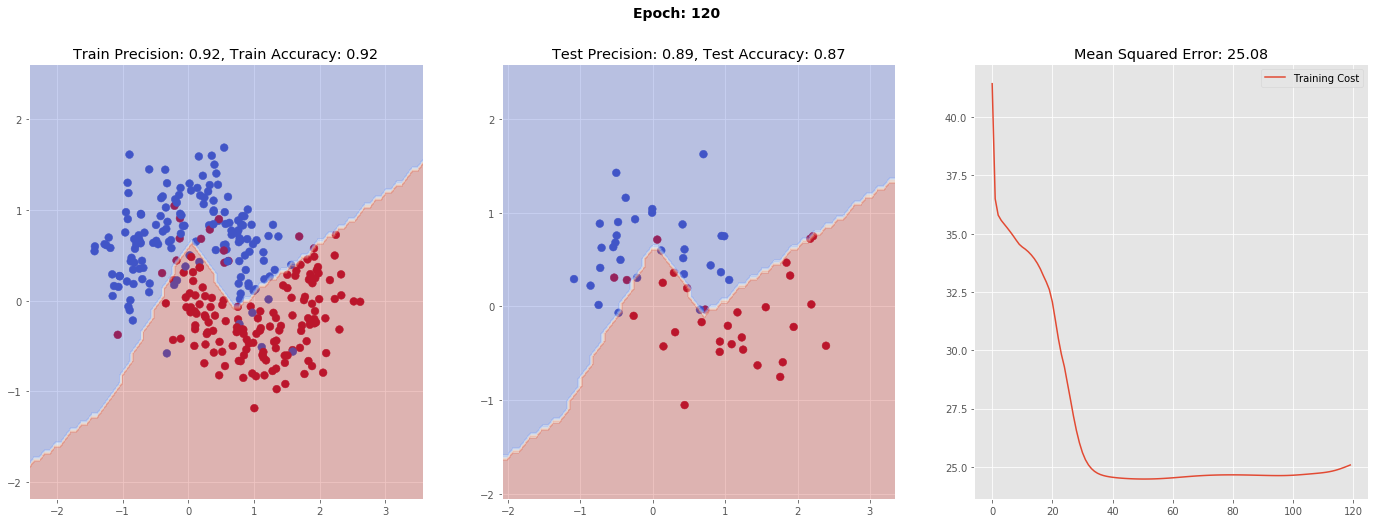

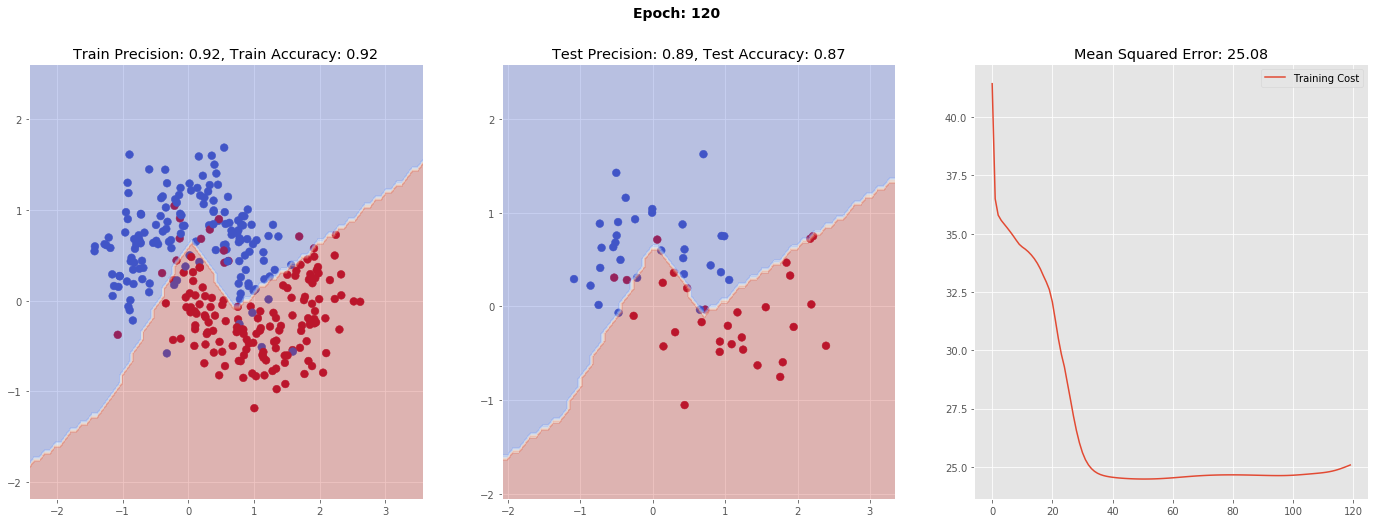

In [12]:
# We have
# sigmoid
# tanh
# relu
# leaky_relu
# elu
# selu

activation_func = tanh
activation_func_derivative = tanh_derivative

# Should clean this up later.
def predict(X):
    predictions = []

    for x in X:
        pred = forward_propagation(x, activation_func)
        pred = np.argmax(pred)
        predictions.append(pred)
    return np.array(predictions)

input_nodes, hidden_nodes, output_nodes,\
    input_activations, hidden_activations, output_activations,\
    input_weights, output_weights,\
    input_stepsize, output_stepsize = initialize(input_dimensions, hidden_dimensions, output_dimensions)

train_with_animation(train_data, test_data, epochs=epochs, learning_rate=learning_rate, plot_step=plot_steps, activation_func = activation_func, activation_func_derivative = activation_func_derivative)

#### leaky_relu

We now try with leaky_relu

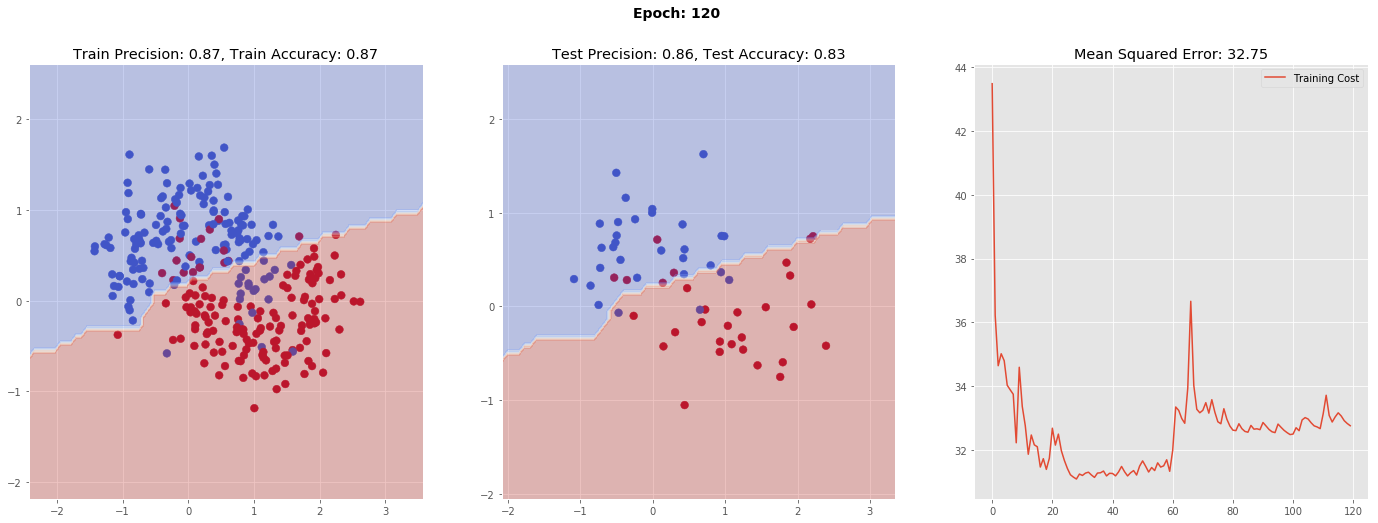

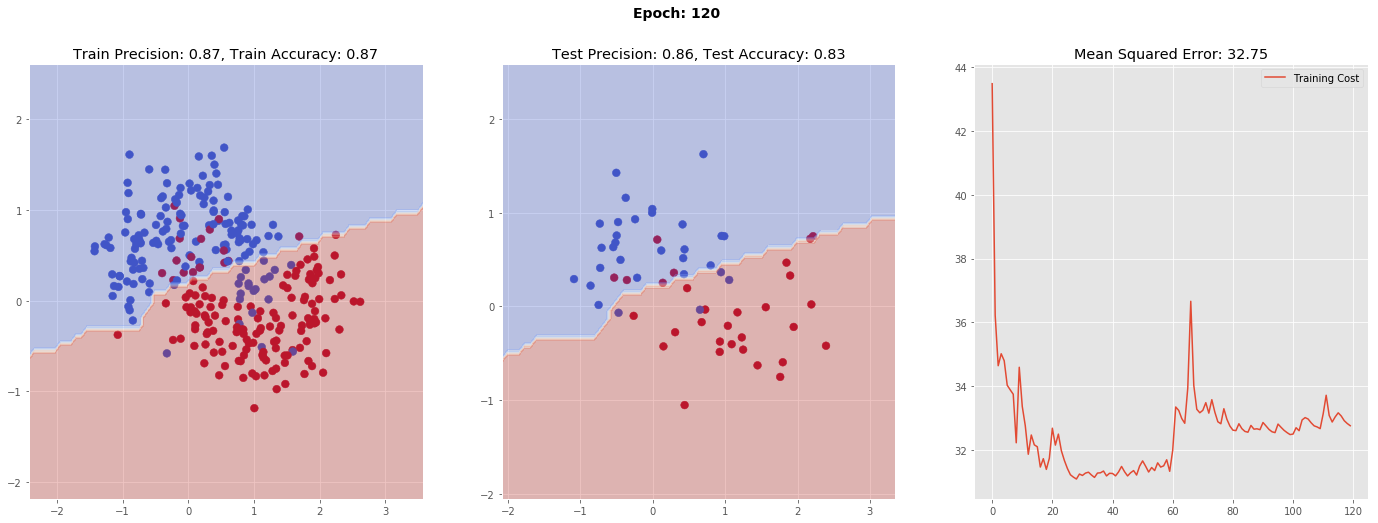

In [13]:
activation_func = leaky_relu
activation_func_derivative = leaky_relu_derivative

# Should clean this up later.
def predict(X):np.random.seed(0)

    predictions = []

    for x in X:
        pred = forward_propagation(x, activation_func)
        pred = np.argmax(pred)
        predictions.append(pred)
    return np.array(predictions)

input_nodes, hidden_nodes, output_nodes,\
    input_activations, hidden_activations, output_activations,\
    input_weights, output_weights,\
    input_stepsize, output_stepsize = initialize(input_dimensions, hidden_dimensions, output_dimensions)

train_with_animation(train_data, test_data, epochs=epochs, learning_rate=learning_rate, plot_step=plot_steps, activation_func = activation_func, activation_func_derivative = activation_func_derivative)

### More Hidden Units

We now try with relu againg, but with more hidden neurons.

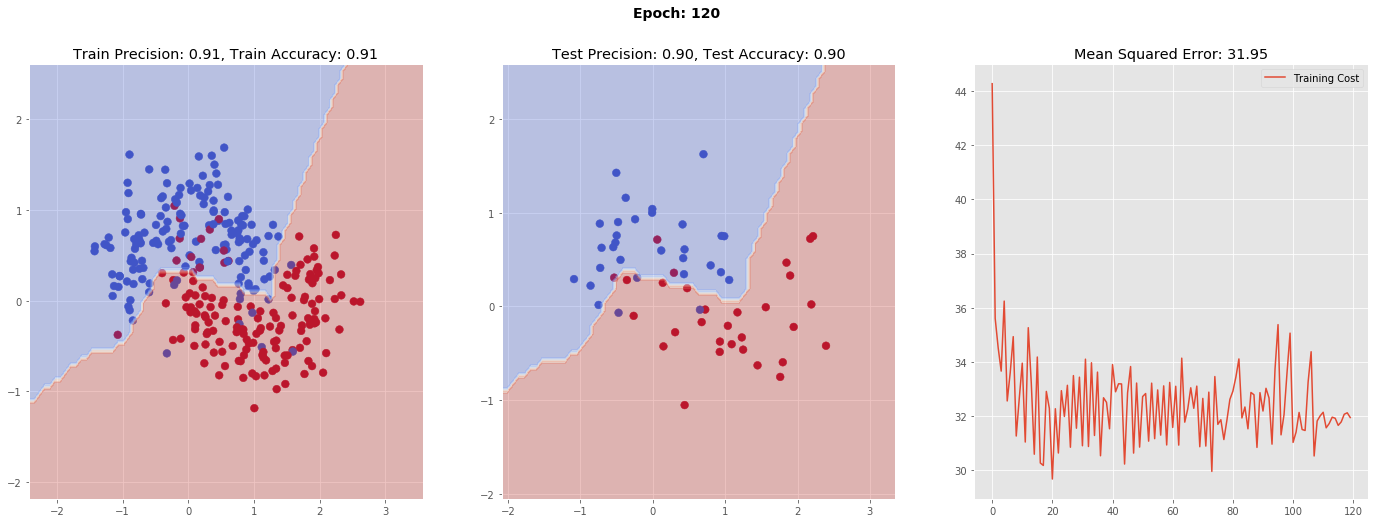

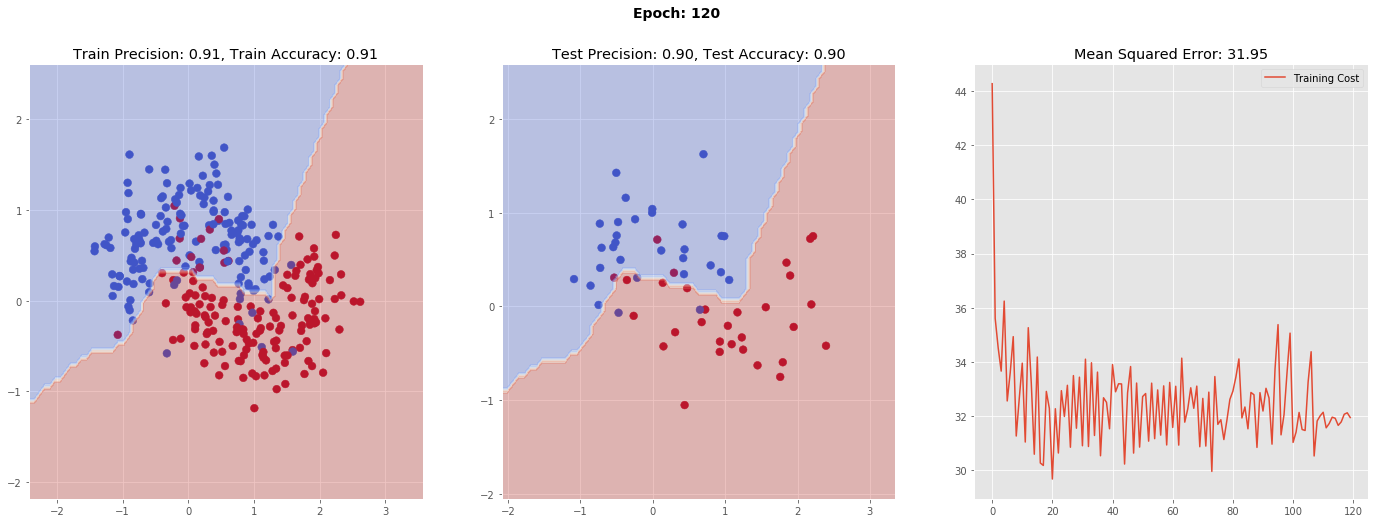

In [14]:
hidden_dimensions = 30

activation_func = relu
activation_func_derivative = relu_derivative

# Should clean this up later.
def predict(X):
    predictions = []

    for x in X:
        pred = forward_propagation(x, activation_func)
        pred = np.argmax(pred)
        predictions.append(pred)
    return np.array(predictions)

input_nodes, hidden_nodes, output_nodes,\
    input_activations, hidden_activations, output_activanp.random.seed(0)
tions,\
    input_weights, output_weights,\
    input_stepsize, output_stepsize = initialize(input_dimensions, hidden_dimensions, output_dimensions)

train_with_animation(train_data, test_data, epochs=epochs, learning_rate=learning_rate, plot_step=plot_steps, activation_func = activation_func, activation_func_derivative = activation_func_derivative)